### Notebook to visualize the behavior of the agents

In [1]:
cd ../../

c:\Users\Yago\Desktop\GISD\TFG\code\cfe_rl


c:\Users\Yago\Desktop\GISD\TFG\code\cfe_rl\.venv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from src.utils import plot_signal, predict_proba, l0_norm, num_subsequences
from src.agents import load_saved_experiment

In [3]:
def calculate_cfe(x1, x2, mask):
    return np.where(mask, x2, x1)

### Setup

In [4]:
experiment = "cca636dde3a5"

agent, env, data = load_saved_experiment(experiment)
agent, env, data

Agent loaded successfully from results\cca636dde3a5\model.zip


(<stable_baselines3.dqn.dqn.DQN at 0x26411943040>,
 <FlatToStartStepWrapper(mode=triangular, actions=4656) <DiscreteEnv(data=ecg200, model=FCN, weights={'adversarial': 0.5, 'sparsity': 0.5, 'contiguity': 0.0})>>,
 <DataManager(dataset='ecg200', model='FCN')>)

### Episode

In [5]:
obs, info = env.reset(train=False)
orig = obs["original"]
nun = obs["nun"]
mask = obs["mask"]
new = calculate_cfe(orig, nun, mask)

steps = [{"step": env.get_n_step(), "mask": env.get_actual_mask()}]
done, end = False, False
total_reward = 0

while not done and not end:
    action, _ = agent.predict(obs, deterministic=True)
    obs, reward, done, end, info = env.step(int(action))
    total_reward += reward
    steps.append(
        {"step": env.get_n_step(), "mask": env.get_actual_mask()}
    )

In [6]:
print(env)

<FlatToStartStepWrapper (triangular) DiscreteEnv>


### Creating GIF

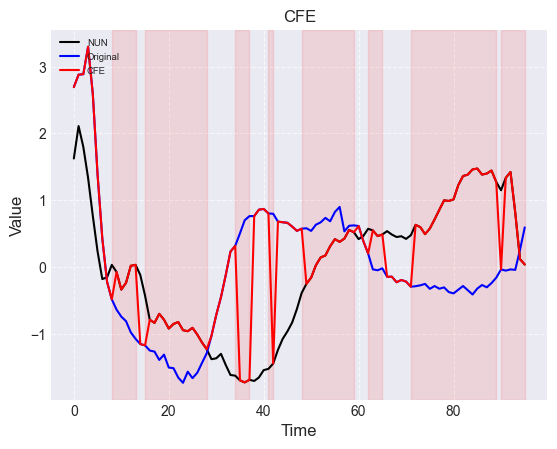

In [7]:
def init():
    ax.set_title("CFE")
    ax.set_xlabel("Time", fontsize=12)
    ax.set_ylabel("Value", fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.7)


def update(frame):
    step_data = steps[frame]
    mask = step_data["mask"]
    plot_signal(orig, nun, mask, ax, dataset=f"Step {step_data['step']}")


plt.style.use("seaborn-v0_8-darkgrid")
fig, ax = plt.subplots()
ani = animation.FuncAnimation(
    fig, update, frames=len(steps), init_func=init, repeat=False, interval=500
)
ani.save(f"./experiments/notebooks/cfe_{data.name}_{env.mode}_{experiment[:4]}.gif", writer="pillow")

### Animation

In [8]:
from IPython.display import HTML

HTML(ani.to_jshtml())

### Final info

CFE succesfully obtained in 14 steps
Total reward = 0.1940519114335384
CFE proba = tensor([[1.6662e-04, 9.9983e-01]])
% of change = 0.5
Nº subsequences = 8


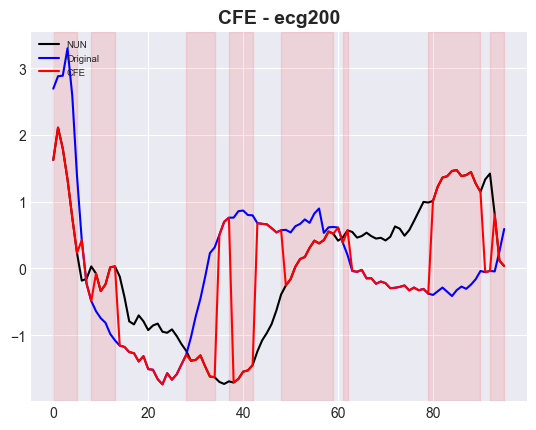

In [9]:
cfe_info = env.get_cfe()
cfe_mask = cfe_info["mask"]
final_cfe = calculate_cfe(orig, nun, cfe_mask)
print(
    f"CFE succesfully obtained in {cfe_info['step']} steps"
    if cfe_info["step"] > 0
    else "The agent couldn't find a CFE"
)
print(f"Total reward = {total_reward}")
print(f"CFE proba = {predict_proba(data.model, final_cfe)[0]}")
print(
    f"% of change = {l0_norm(cfe_mask)/cfe_mask.size}"
)
print(f"Nº subsequences = {num_subsequences(cfe_mask)}")
fig, ax = plt.subplots()
plot_signal(orig, nun, cfe_mask, ax, data.name)